# Movies Recommender System and Topic Modeling
**By: Sarah Alabdulwahab & Asma Althakafi**
> For this Project, we will try to find the degree of similarity between movies in order to recommend movies based on their plots and perform topic modeling on the movie plots as well.

In [1]:
#supress warnings
import warnings
warnings.filterwarnings('ignore')

#progress meter
from tqdm import tqdm

## Cleaning

In [2]:
import pandas as pd
movies_df = pd.read_csv('Data/movies.csv')
movies_df.head()

,original_title,overview,genres,keywords,imdb_plot
0,Twelve Monkeys,"In the year 2035, convict James Cole reluctant...",Science-Fiction Thriller Mystery,"schizophrenia philadelphia, pennsylvania stock...","In a future world devastated by disease, a con..."
1,Across the Sea of Time,"A young Russian boy, Thomas Minton, travels to...",Adventure History Drama Family,NaN,"A young Russian boy, Thomas Minton, travels to..."
2,Restoration,"An aspiring young physician, Robert Merivel fo...",Drama Romance,jealousy medicine fountain court wealth spanie...,The exiled royal physician to King Charles II ...
3,The Crossing Guard,"After his daughter died in a hit and run, Fred...",Drama Thriller,loss of loved one hit-and-run revenge tragedy,Freddy Gale is a seedy jeweller who has sworn ...
4,Once Upon a Time... When We Were Colored,This film relates the story of a tightly conne...,Romance Drama,racial segregation family relationships rural ...,A narrator tells the story of his childhood ye...


In [3]:
print('The dataset contains',movies_df.shape[0],'movies and',movies_df.shape[1],'features')

The dataset contains 3133 movies and 5 features


In [4]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3133 entries, 0 to 3132
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   original_title  3133 non-null   object
 1   overview        3133 non-null   object
 2   genres          3133 non-null   object
 3   keywords        2241 non-null   object
 4   imdb_plot       3111 non-null   object
dtypes: object(5)
memory usage: 122.5+ KB


We decided to fill the null values with empty strings, therefore, we won't lose data.

In [5]:
movies_df.fillna('', inplace=True)

In order to increase the word count, we will concatenate the `overview`, `imdb_plot`, and `keywords` features, then drop them since they are no longer useful.

In [6]:
movies_df['plot'] = movies_df['overview'] + movies_df['imdb_plot'] + movies_df['keywords']
movies_df.drop(columns=['overview','imdb_plot','keywords'], inplace = True)

Store two plots: the original and a clean one.

In [7]:
movies_df['plot_clean'] = movies_df['plot'] 

Splitting the genres into a list for easier access.

In [8]:
movies_df['genres'] = movies_df['genres'].str.split()
movies_df['genres'].head()

0    [Science-Fiction, Thriller, Mystery]
1     [Adventure, History, Drama, Family]
2                        [Drama, Romance]
3                       [Drama, Thriller]
4                        [Romance, Drama]
Name: genres, dtype: object

In [9]:
movies_df.head()

,original_title,genres,plot,plot_clean
0,Twelve Monkeys,"[Science-Fiction, Thriller, Mystery]","In the year 2035, convict James Cole reluctant...","In the year 2035, convict James Cole reluctant..."
1,Across the Sea of Time,"[Adventure, History, Drama, Family]","A young Russian boy, Thomas Minton, travels to...","A young Russian boy, Thomas Minton, travels to..."
2,Restoration,"[Drama, Romance]","An aspiring young physician, Robert Merivel fo...","An aspiring young physician, Robert Merivel fo..."
3,The Crossing Guard,"[Drama, Thriller]","After his daughter died in a hit and run, Fred...","After his daughter died in a hit and run, Fred..."
4,Once Upon a Time... When We Were Colored,"[Romance, Drama]",This film relates the story of a tightly conne...,This film relates the story of a tightly conne...


### Spacy
We will use Spacy in order to remove named entities from each movie plot. 
>You can install Spacy using pip: `!pip install spacy` and download trained pipelines in English: `!python -m spacy download en_core_web_sm`

In [10]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [11]:
for i, txt in tqdm(enumerate(movies_df['plot_clean'])):
    document = nlp(txt)
    movies_df['plot_clean'][i] = " ".join([ent.text for ent in document if not ent.ent_type_])

3133it [03:23, 15.39it/s]


### NLTK and LancasterStemmer
We will use NLTK and LancasterStemmer in order to clean the movies plots.

In [12]:
import nltk
from nltk.stem import LancasterStemmer
stemmer = LancasterStemmer()

In [13]:
#stemming and removing non alpha words
clean_plots = []
for plot in tqdm(movies_df['plot_clean']):
    words = nltk.word_tokenize(plot)
    clean_plots.append(' '.join([stemmer.stem(word).lower() for word in words if word.isalpha()]))
    
movies_df['plot_clean'] = clean_plots

100%|██████████| 3133/3133 [00:28<00:00, 111.74it/s]


## Word Embedding - CountVectorizer and TF-IDF

In [14]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
cv = CountVectorizer(stop_words='english')
tfidf = TfidfVectorizer(stop_words='english')

In [15]:
def embed(transformer, corpus):
    return transformer.fit_transform(corpus)

## Visualization using WordCloud

We will use WordCloud in order to visualize the most frequent words in the movie plots. 
>You can install WordCloud using pip: `!pip install wordcloud`

In [16]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [17]:
def plot_WordCloud(text):
    wc = WordCloud(background_color='white', max_words=1000, stopwords= set(STOPWORDS))
    wc.generate(text)

    plt.figure(figsize = (15,10))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off');

Combining all of the plots to see the most frequent words across all of them.

In [18]:
all_plots = ""
for plot in movies_df['plot']:
    all_plots += plot + " "

Collecting Action, Drama, Horror, Sci-Fi, and Comedy movie plots to see the most frequent words across these genres.

In [19]:
action, drama, horror, scifi, comedy = '', '', '', '', ''

for i, genres in enumerate(movies_df['genres']):
    plot = movies_df['plot'][i]
    if 'Action' in genres:
        action += plot
    if 'Drama' in genres:
        drama += plot
    if 'Horror' in genres:
        horror += plot
    if 'Science-Fiction' in genres:
        scifi += plot
    if 'Comedy' in genres:
        comedy += plot

#### Most Frequent Words in All Movie Plots

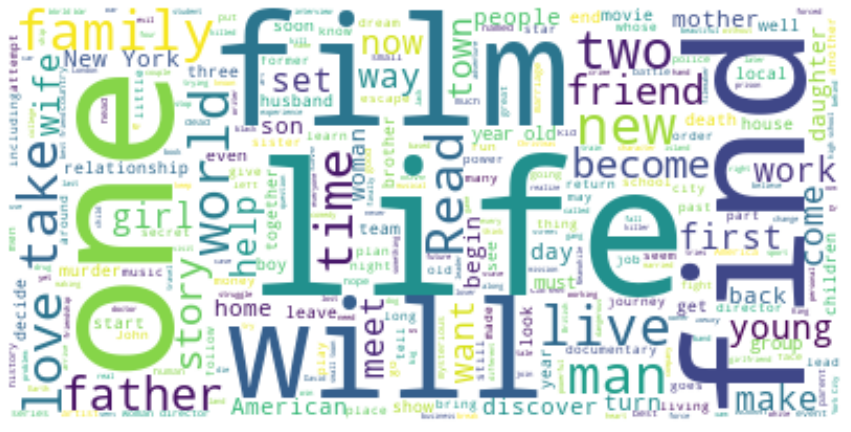

In [20]:
plot_WordCloud(all_plots)

#### Most Frequent Words in Action Movie Plots

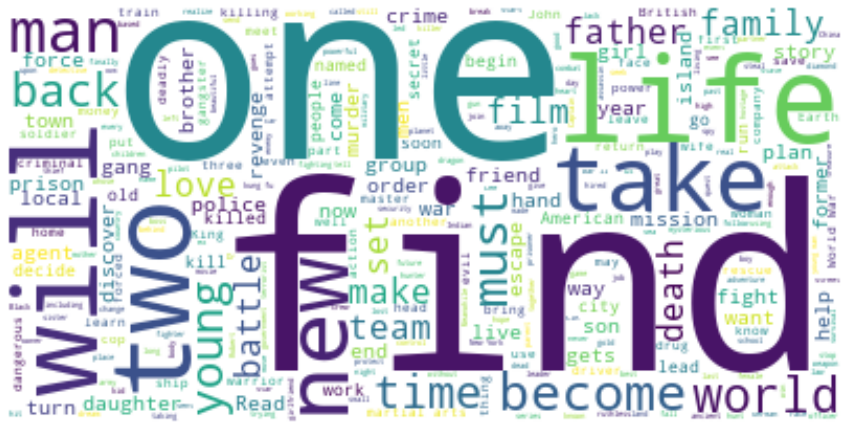

In [21]:
plot_WordCloud(action)

#### Most Frequent Words in Drama Movie Plots

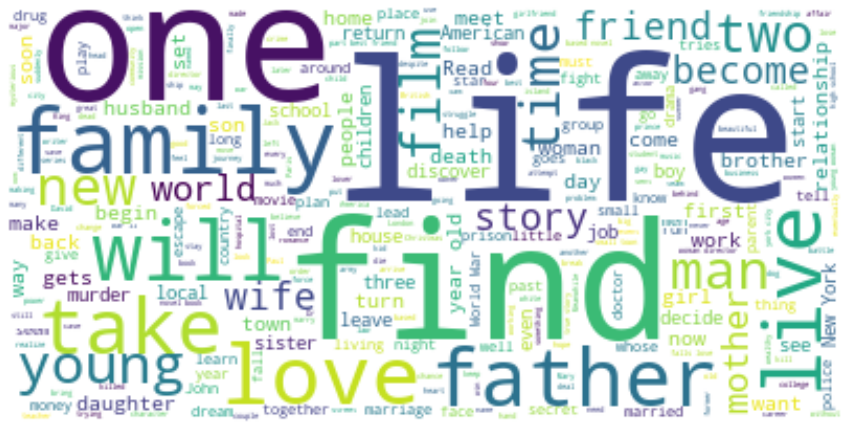

In [22]:
plot_WordCloud(drama)

#### Most Frequent Words in Horror Movie Plots

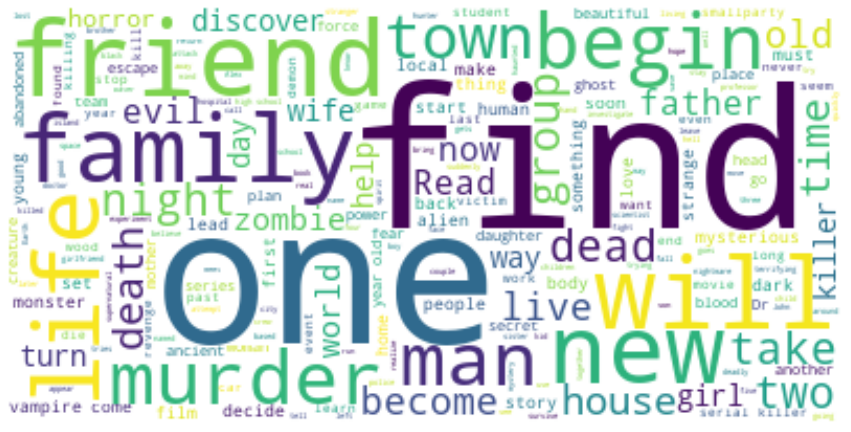

In [23]:
plot_WordCloud(horror)

#### Most Frequent Words in Sci-Fi Movie Plots

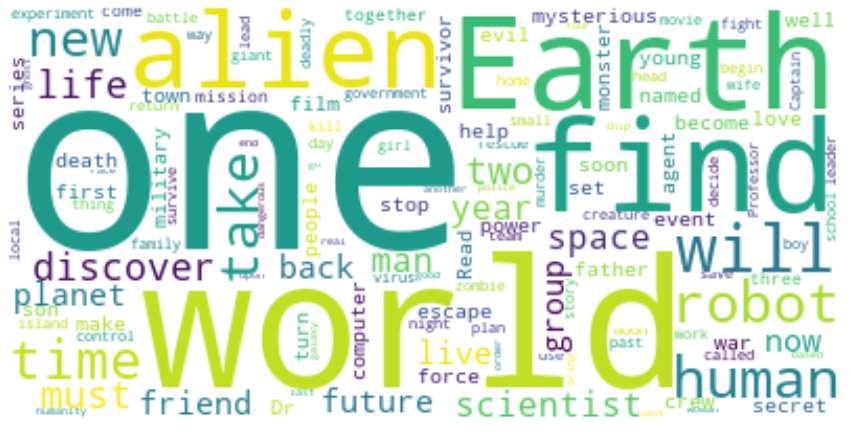

In [24]:
plot_WordCloud(scifi)

#### Most Frequent Words in Comedy Movie Plots

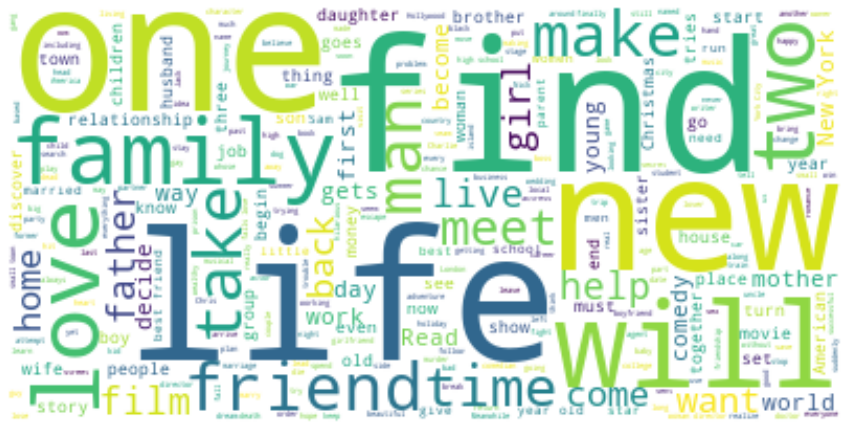

In [25]:
plot_WordCloud(comedy)

## Content-based Recommender System

In [26]:
from sklearn.metrics.pairwise import cosine_similarity 

In [27]:
def find_similar_movie(title, doc_word, num_of_movies=3):
    index = movies_df[movies_df['original_title'] == title].index[0] #index of the given movie
    similarities = []
    for i in range(doc_word.shape[0]):
        similarities.append([cosine_similarity(doc_word[index], doc_word[i])[0][0], 
                             movies_df['original_title'][i], movies_df['genres'][i],index,i])
    
    #store the results sorted from the most to least similar
    results = sorted(similarities, reverse=True)[1:num_of_movies+1]
    
    #display results
    print('The movie you chose is', title)
    print(' - Genres:',', '.join(movies_df['genres'][index]),'\n')
    print('The recommended movies:')
    for movie in results:
        print(f' - {movie[1]} | Similarity score: {round(movie[0]*100)}%')
        print('   - Genres:',', '.join(movie[2]))

In [28]:
movie_title = 'Twelve Monkeys'

### Original Plot with CountVectorizer

In [29]:
find_similar_movie(movie_title, embed(cv, movies_df['plot']))

The movie you chose is Twelve Monkeys
 - Genres: Science-Fiction, Thriller, Mystery 

The recommended movies:
 - Day of the Dead 2: Contagium | Similarity score: 20%
   - Genres: Horror, Science-Fiction
 - Carriers | Similarity score: 18%
   - Genres: Action, Drama, Horror, Science-Fiction, Thriller
 - Solos | Similarity score: 18%
   - Genres: Horror, Thriller, Science-Fiction, Foreign


### Clean Plot with CountVectorizer

In [30]:
find_similar_movie(movie_title, embed(cv, movies_df['plot_clean']))

The movie you chose is Twelve Monkeys
 - Genres: Science-Fiction, Thriller, Mystery 

The recommended movies:
 - Carriers | Similarity score: 26%
   - Genres: Action, Drama, Horror, Science-Fiction, Thriller
 - Solos | Similarity score: 23%
   - Genres: Horror, Thriller, Science-Fiction, Foreign
 - Day of the Dead 2: Contagium | Similarity score: 22%
   - Genres: Horror, Science-Fiction


### Original Plot with TF-IDF

In [31]:
find_similar_movie(movie_title, embed(tfidf, movies_df['plot']))

The movie you chose is Twelve Monkeys
 - Genres: Science-Fiction, Thriller, Mystery 

The recommended movies:
 - Carriers | Similarity score: 19%
   - Genres: Action, Drama, Horror, Science-Fiction, Thriller
 - Awa buriifu etanitei | Similarity score: 16%
   - Genres: Drama, Fantasy, Romance
 - Day of the Dead 2: Contagium | Similarity score: 16%
   - Genres: Horror, Science-Fiction


### Clean Plot with TF-IDF

In [32]:
find_similar_movie(movie_title, embed(tfidf, movies_df['plot_clean']))

The movie you chose is Twelve Monkeys
 - Genres: Science-Fiction, Thriller, Mystery 

The recommended movies:
 - Carriers | Similarity score: 31%
   - Genres: Action, Drama, Horror, Science-Fiction, Thriller
 - Awa buriifu etanitei | Similarity score: 25%
   - Genres: Drama, Fantasy, Romance
 - Solos | Similarity score: 21%
   - Genres: Horror, Thriller, Science-Fiction, Foreign


**For the content-based recommender system, the best results given were using the clean plots with CountVectorizer**

## Topic Modeling
We tried a different cleaning process in order to get better results in topic modeling, using lemmatization and POS tagging.

In [33]:
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from collections import defaultdict

lemmatizer = WordNetLemmatizer()

tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

In [34]:
clean_plots = []

for plot in tqdm(movies_df['plot']):
    
    #remove specific pos tag
    tokens = nltk.word_tokenize(plot)
    tagged_sentence = nltk.tag.pos_tag(tokens)
    new_plot = ' '.join([word for word,tag in tagged_sentence if tag != 'NNP' and tag != 'NNPS' and tag != 'PRP' and tag != 'DT' and tag != 'NN' and tag != 'RB' and tag != 'NNS'])
    
    #remove named entity 
    document = nlp(new_plot)
    new_plot = " ".join([ent.text for ent in document if not ent.ent_type_ ])
    
    #apply lemmatizition
    newtext = ""
    tokens = word_tokenize(new_plot)
    for token, tag in pos_tag(tokens):
        lemma = lemmatizer.lemmatize(token, tag_map[tag[0]])
        newtext += " " + lemma
    new_plot = newtext
    
    #remove specific words 
    clean_plots.append(" ".join([word for word in new_plot.split() if word not in ['film','story','year','director','want','old','young']]))

100%|██████████| 3133/3133 [03:54<00:00, 13.35it/s]


### Latent Semantic Analysis (LSA)

In [35]:
from sklearn.decomposition import TruncatedSVD

In [36]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic", ix)
        else:
            print("\nTopic:",topic_names[ix])
        print(", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [37]:
def LSA(transformer, corpus):
    lsa = TruncatedSVD(19)
    doc_topic = lsa.fit_transform(embed(transformer, corpus))
    
    print('Variance Ratio:')
    print(lsa.explained_variance_ratio_,'\n')
    
    print('Sum of Variance Ratio:',lsa.explained_variance_ratio_.sum(),'\n')
    
    print('Topics:')
    display_topics(lsa, transformer.get_feature_names(), 10)
    
    column_names = []
    for i in range(0,19):
        column_names.append('Topic_' + str(i))
     
    #if we want more details 
    #return pd.DataFrame(doc_topic.round(5),index = corpus,columns = column_names)

#### Original Plot with CountVectorizer

In [38]:
LSA(cv, movies_df['plot'])

Variance Ratio:
[0.00351354 0.00799139 0.00624724 0.00571564 0.00513558 0.00480306
 0.00468428 0.00434335 0.00379617 0.00367955 0.00354226 0.0034543
 0.00341989 0.00325272 0.00317436 0.00300656 0.00287629 0.00285089
 0.0026749 ] 

Sum of Variance Ratio: 0.07816196250462502 

Topics:

Topic 0
life, new, film, love, family, man, world, young, story, old

Topic 1
film, world, story, documentary, war, director, music, american, movie, footage

Topic 2
new, york, city, school, high, christmas, world, team, friends, comedy

Topic 3
war, world, ii, army, men, british, group, german, based, story

Topic 4
life, new, world, york, city, lives, journey, work, love, live

Topic 5
love, woman, man, young, war, york, falls, story, married, city

Topic 6
family, war, love, new, father, story, film, son, world, york

Topic 7
school, love, high, story, year, life, family, teacher, world, friends

Topic 8
story, old, year, years, world, father, man, music, time, documentary

Topic 9
man, school, young, 

We can differentiate between a few of the topics. For example, topic 3 and topic 4, which are war and romance, however, the other topics are overlapping.

#### Clean Plot with CountVectorizer

In [39]:
LSA(cv, clean_plots)

Variance Ratio:
[0.00681008 0.01209689 0.01020918 0.00743699 0.00675333 0.00667846
 0.00630544 0.00609064 0.00600457 0.00575819 0.00556153 0.00553293
 0.00534525 0.0052808  0.00515248 0.0049606  0.00478566 0.00469473
 0.00458911] 

Sum of Variance Ratio: 0.1200468651090525 

Topics:

Topic 0
make, new, come, try, live, leave, meet, begin, know, turn

Topic 1
new, help, begin, turn, high, save, open, evil, spend, magical

Topic 2
make, new, documentary, global, league, everyday, cut, difficult, include, compete

Topic 3
come, make, small, best, gay, high, big, begin, new, win

Topic 4
meet, marry, leave, live, fall, love, work, new, help, return

Topic 5
tell, live, true, base, include, like, great, documentary, musical, know

Topic 6
leave, tell, know, turn, dead, begin, come, new, lose, make

Topic 7
begin, meet, fall, true, start, follow, set, mysterious, high, marry

Topic 8
tell, kill, meet, try, marry, new, good, make, black, local

Topic 9
live, begin, kill, lead, mysterious, bas

We can differentiate between a few of the topics. For example, topic 11 and topic 18, which are crime and romance, however, the other topics are overlapping.

#### Original Plot with TF-IDF

In [40]:
LSA(tfidf, movies_df['plot'])

Variance Ratio:
[0.00080075 0.00289771 0.00234277 0.00223775 0.00202975 0.00189631
 0.00176737 0.00164735 0.00156984 0.00154518 0.00149999 0.00145987
 0.00139107 0.00134794 0.00133714 0.00129615 0.00126455 0.00125129
 0.00121147] 

Sum of Variance Ratio: 0.030794244082215365 

Topics:

Topic 0
life, new, family, film, love, man, young, world, story, old

Topic 1
film, war, world, documentary, story, music, footage, american, interviews, history

Topic 2
war, ii, army, world, soldiers, island, german, british, mission, police

Topic 3
christmas, santa, war, claus, holiday, world, spirit, eve, new, ii

Topic 4
school, high, team, town, students, killer, group, friends, space, new

Topic 5
school, war, high, mother, family, love, teacher, ii, children, year

Topic 6
york, new, war, city, wife, husband, love, comedy, married, police

Topic 7
new, space, york, earth, island, love, friends, city, alien, game

Topic 8
new, york, family, city, police, children, gay, story, world, lives

Topic 

We can differentiate between a few of the topics. For example, topic 2 and topic 4, which are war and crime, however, the other topics are overlapping.

#### Clean Plot with TF-IDF

In [41]:
LSA(tfidf, clean_plots)

Variance Ratio:
[0.00163259 0.00345621 0.00330653 0.00308202 0.00277883 0.00265644
 0.0025275  0.00244906 0.00241218 0.00238879 0.00235876 0.00231377
 0.00225787 0.00221573 0.00219249 0.00216186 0.00214719 0.0021108
 0.00205267] 

Sum of Variance Ratio: 0.0465012982578105 

Topics:

Topic 0
make, new, come, try, leave, live, meet, know, begin, turn

Topic 1
marry, kill, fall, meet, leave, local, return, run, try, small

Topic 2
marry, make, meet, fall, love, musical, live, work, wealthy, play

Topic 3
new, help, high, start, best, love, win, fall, begin, meet

Topic 4
make, try, kill, small, big, best, high, start, dead, local

Topic 5
come, small, local, live, big, high, leave, gay, force, town

Topic 6
leave, make, begin, mysterious, lose, return, dead, discover, turn, learn

Topic 7
work, leave, live, try, include, new, lead, like, stand, return

Topic 8
tell, dead, kill, meet, new, come, start, begin, real, high

Topic 9
leave, kill, live, best, musical, new, black, play, join, whi

We can differentiate between a few of the topics. For example, topic 1 and topic 3, which are crime and romance, however, the other topics are overlapping.

**For LSA, the best results given were using the Original Plot with CountVectorizer.**

### Latent Dirichlet Allocation (LDA)
We will use pyLDAvis in order to visualize the most frequent words in each topic. 
>You can install pyLDAvis using pip: `!pip install pyLDAvis`

In [42]:
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [44]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
from sklearn.decomposition import LatentDirichletAllocation

In [45]:
def embed_advanced(transformer_type, corpus):
    transformer = transformer_type(strip_accents = 'unicode', stop_words = 'english',lowercase = True, 
                                   token_pattern = r'\b[a-zA-Z]{3,}\b',max_df = 0.5, min_df = 10) 
    return transformer, transformer.fit_transform(corpus)

In [46]:
def LDA(transformer_type, corpus):
    lda = LatentDirichletAllocation(n_components=19, random_state=0)
    transformer, embed_corpus = embed_advanced(transformer_type, corpus)
    lda.fit(embed_corpus)
    return pyLDAvis.sklearn.prepare(lda, embed_corpus, transformer)

#### Original Plot with CountVectorizer

In [47]:
LDA(CountVectorizer, movies_df['plot'])

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
16    -0.119304  0.098121       1        1  7.775583
12     0.183530  0.141512       2        1  7.151249
7     -0.128075  0.029207       3        1  7.049620
14    -0.037237 -0.000989       4        1  6.577813
17    -0.132647  0.053864       5        1  6.120645
18    -0.023209 -0.125632       6        1  5.919065
4      0.155604 -0.051648       7        1  5.817990
13    -0.112812 -0.066860       8        1  5.777674
9     -0.040629  0.075409       9        1  5.677766
5      0.162096  0.066251      10        1  5.499814
15    -0.036136  0.010213      11        1  5.496476
6     -0.090798  0.055707      12        1  5.064334
8     -0.043636 -0.144746      13        1  4.647552
2      0.084850 -0.110455      14        1  4.217590
3      0.015596 -0.031179      15        1  4.193326
0      0.051341 -0.043555      16        1  3.405500
11     0.095527  0.071380      17        1  3.332644
10     0.069139 -0.086168      18        1  3.298234
1     -0.053202  0.059569      19        1  2.977125, topic_info=        Term         Freq        Total Category  logprob  loglift
3959     war   597.000000   597.000000  Default  30.0000  30.0000
1399    film  1191.000000  1191.000000  Default  29.0000  29.0000
2417   music   309.000000   309.000000  Default  28.0000  28.0000
687   comedy   263.000000   263.000000  Default  27.0000  27.0000
1335  family   923.000000   923.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
4047   woman    20.508632   717.065319  Topic19  -5.6625  -0.0401
1399    film    20.903945  1191.863794  Topic19  -5.6434  -0.5291
4014    wife    19.504651   515.763699  Topic19  -5.7126   0.2392
3708    time    19.820264   762.092925  Topic19  -5.6966  -0.1352
2937    read    18.976747   760.294121  Topic19  -5.7401  -0.1763

[1288 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
6         8  0.540180    abroad
6        10  0.135045    abroad
6        13  0.270090    abroad
18        1  0.038619  accident
18        3  0.270334  accident
...     ...       ...       ...
4092     15  0.106728  youngest
4094      3  0.079299  youthful
4094      4  0.555092  youthful
4094     16  0.158598  youthful
4094     19  0.079299  youthful

[6793 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 13, 8, 15, 18, 19, 5, 14, 10, 6, 16, 7, 9, 3, 4, 1, 12, 11, 2])

We can differentiate between a few of the topics. For example, topic 6 and topic 13, which are war and crime however, the other topics are overlapping.

#### Clean Plot with CountVectorizer

In [48]:
LDA(CountVectorizer, clean_plots)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
16     0.070002 -0.041204       1        1  7.294045
12     0.087029  0.111516       2        1  6.800228
18     0.090674  0.093781       3        1  6.400029
4      0.112398  0.081334       4        1  6.112575
13     0.044528  0.050250       5        1  6.008337
1      0.086906  0.056513       6        1  5.960353
15     0.050908 -0.044781       7        1  5.702543
9     -0.158516  0.071013       8        1  5.602212
5      0.030618 -0.071163       9        1  5.296920
17    -0.058453  0.044089      10        1  5.157571
7     -0.039368 -0.055326      11        1  4.930223
8     -0.244976  0.045986      12        1  4.917300
2      0.003797 -0.043233      13        1  4.709364
11     0.058768  0.022927      14        1  4.598577
0      0.020596 -0.157348      15        1  4.409158
6      0.035411 -0.112474      16        1  4.408410
3     -0.101646  0.017812      17        1  4.123192
14    -0.048591 -0.096673      18        1  4.057507
10    -0.040086  0.026982      19        1  3.511456, topic_info=             Term        Freq       Total Category  logprob  loglift
280          dead  209.000000  209.000000  Default  30.0000  30.0000
780         marry  289.000000  289.000000  Default  29.0000  29.0000
121         black  158.000000  158.000000  Default  28.0000  28.0000
696          kill  374.000000  374.000000  Default  27.0000  27.0000
1151        small  316.000000  316.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
714          lead   15.867278  374.221712  Topic19  -4.9663   0.1886
345   documentary   13.378772  171.212898  Topic19  -5.1369   0.7999
768          make   14.999833  920.905625  Topic19  -5.0225  -0.7682
1252         tell   14.081637  427.701997  Topic19  -5.0857  -0.0644
860         offer   12.421518  133.238169  Topic19  -5.2111   0.9764

[1182 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
5         1  0.423290    abuse
5         3  0.060470    abuse
5        11  0.181410    abuse
5        13  0.181410    abuse
5        16  0.120940    abuse
...     ...       ...      ...
1418     11  0.152412    wrong
1418     12  0.025402    wrong
1418     14  0.012701    wrong
1419      4  0.921452  younger
1419     19  0.048497  younger

[5654 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 13, 19, 5, 14, 2, 16, 10, 6, 18, 8, 9, 3, 12, 1, 7, 4, 15, 11])

majority of topics are overlapping.

#### Original Plot with TF-IDF

In [49]:
LDA(TfidfVectorizer, movies_df['plot'])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14     0.238524  0.000132       1        1  72.847582
15    -0.252216  0.167968       2        1   6.531830
5     -0.215540 -0.194683       3        1   5.615577
11     0.002940  0.005681       4        1   1.352148
4      0.008731  0.007504       5        1   1.210821
7      0.010896  0.003236       6        1   1.167878
17     0.009541 -0.010523       7        1   1.165093
2      0.018039 -0.002490       8        1   1.077591
18     0.015348  0.001516       9        1   0.934787
3      0.020277  0.003943      10        1   0.891774
16     0.017455  0.001970      11        1   0.872300
13     0.018531  0.001973      12        1   0.869940
0      0.018052  0.004380      13        1   0.824917
6      0.017195  0.003281      14        1   0.795154
9      0.014107 -0.000766      15        1   0.794451
10     0.015143  0.002772      16        1   0.783319
12     0.015239  0.000567      17        1   0.769750
8      0.013772  0.001376      18        1   0.747598
1      0.013966  0.002164      19        1   0.747490, topic_info=           Term       Freq      Total Category  logprob  loglift
604   christmas  20.000000  20.000000  Default  30.0000  30.0000
3105       rock  12.000000  12.000000  Default  29.0000  29.0000
3170      santa   8.000000   8.000000  Default  28.0000  28.0000
288        band  12.000000  12.000000  Default  27.0000  27.0000
1399       film  53.000000  53.000000  Default  26.0000  26.0000
...         ...        ...        ...      ...      ...      ...
878     cutting   0.034502   1.839468  Topic19  -8.3378   0.9200
3337    singing   0.034502   3.418072  Topic19  -8.3378   0.3004
3112       roll   0.034502   3.476563  Topic19  -8.3378   0.2834
374       blind   0.034502   4.601374  Topic19  -8.3378   0.0031
332      beings   0.034502   2.485466  Topic19  -8.3378   0.6190

[786 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
2         7  0.586558  abilities
6         3  0.430660     abroad
7         6  0.402262    absence
25        2  0.886223    accused
30        1  0.879053    actions
...     ...       ...        ...
4064      1  0.979518      world
4086      1  0.976577       year
4087      1  0.992433      years
4090      1  0.984452      young
4097      7  0.717086    zombies

[640 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 16, 6, 12, 5, 8, 18, 3, 19, 4, 17, 14, 1, 7, 10, 11, 13, 9, 2])

majority of topics are overlapping.

#### Clean Plot with TF-IDF

In [50]:
LDA(TfidfVectorizer, clean_plots)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
16    -0.128906 -0.024992       1        1  18.624046
12    -0.131665 -0.032495       2        1  12.289249
17    -0.095293  0.021256       3        1  10.512446
6     -0.078333 -0.024030       4        1   7.189950
18    -0.111412 -0.059713       5        1   6.928488
13    -0.128213 -0.029446       6        1   6.197200
7     -0.050537 -0.016036       7        1   5.328921
3     -0.003163  0.155058       8        1   5.214565
5     -0.024617  0.096030       9        1   4.760017
15     0.014108  0.000819      10        1   3.047976
0      0.037274  0.004944      11        1   2.888564
9      0.057195  0.143476      12        1   2.818678
11     0.077333  0.077877      13        1   2.603304
2      0.065207 -0.034066      14        1   2.238234
1      0.042890 -0.063721      15        1   2.122287
4      0.085743 -0.041728      16        1   1.993352
8      0.106721 -0.047467      17        1   1.936694
14     0.129861 -0.086154      18        1   1.883917
10     0.135805 -0.039611      19        1   1.422113, topic_info=             Term       Freq      Total Category  logprob  loglift
345   documentary  27.000000  27.000000  Default  30.0000  30.0000
642       include  42.000000  42.000000  Default  29.0000  29.0000
1414        write  25.000000  25.000000  Default  28.0000  28.0000
922          post   8.000000   8.000000  Default  27.0000  27.0000
1185        stand  20.000000  20.000000  Default  26.0000  26.0000
...           ...        ...        ...      ...      ...      ...
1017       regard   0.869760   6.376026  Topic19  -5.3096   2.2609
1078        rural   1.206341  11.326513  Topic19  -4.9825   2.0135
592         heavy   0.878151   7.050373  Topic19  -5.3000   2.1700
1352      various   1.235428  12.717970  Topic19  -4.9587   1.9214
1120       sexual   1.017411  13.515904  Topic19  -5.1528   1.6664

[1011 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1         4  0.430711  abduct
1         5  0.215355  abduct
1        16  0.215355  abduct
3         4  0.371009  aboard
3        13  0.185505  aboard
...     ...       ...     ...
1418      1  0.608485   wrong
1418      2  0.067609   wrong
1418      7  0.135219   wrong
1418     10  0.067609   wrong
1418     13  0.067609   wrong

[3200 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 13, 18, 7, 19, 14, 8, 4, 6, 16, 1, 10, 12, 3, 2, 5, 9, 15, 11])

majority of topics are overlapping.

**For LDA, the best results given were using the Original Plot with CountVectorizer.**

# ---------------------------------------------------------------------------------------------------------

# The Following are Extra Attempts
1. Classification 
    - Multilabel
    - Single Label
2. Clustering

## Classification
We will try four different methods:
1. Multilabel Classification
    - With All Genres
    - With Most Common Genres
2. Single Label Classification
    - With All Genres
    - With Most Common Genres

**Note:** All methods are using `MultinomialNB`

In [51]:
#for splitting the data
from sklearn.model_selection import train_test_split

#for classification
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB

#for evaluating model performance
from sklearn import metrics

In [52]:
def split(X, y, transformer):
    return train_test_split(embed(transformer, X), y, test_size=.2, random_state=0)

### Multilabel Classification
Using MultiLabelBinarizer and OneVsRestClassifier

In [53]:
mlb = MultiLabelBinarizer()
mlb_y = mlb.fit_transform(movies_df['genres'])
mlb_y

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [54]:
y = pd.DataFrame(mlb_y, columns = mlb.classes_)
y.head()

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science-Fiction,Thriller,War,Western
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0
1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0


In [55]:
def multilabel_classification(X, y, transformer):
    X_train, X_test, y_train, y_test = split(X, y, transformer)
    
    model = OneVsRestClassifier(MultinomialNB())
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    results = metrics.classification_report(y_test, y_pred, output_dict = True)
    
    return [model.score(X_test, y_test), results['weighted avg']['precision'], results['weighted avg']['recall'], 
            results['weighted avg']['f1-score'], model.score(X_train, y_train)]

In [56]:
def get_multilabel_results(y):
    original_cv = multilabel_classification(movies_df['plot'], y, cv)
    original_tfidf = multilabel_classification(movies_df['plot'], y, tfidf)
    clean_cv = multilabel_classification(movies_df['plot_clean'], y, cv)
    clean_tfidf = multilabel_classification(movies_df['plot_clean'], y, tfidf)
    return pd.DataFrame(data = [original_cv, original_tfidf, clean_cv, clean_tfidf], 
                        columns = ['Accuracy','Precision','Recall','F1','Train Accuracy'],
                        index = ['Original Plot with CountVectorizer', 'Original Plot with TF-IDF', 
                                 'Clean Plot with CountVectorizer', 'Clean Plot with TF-IDF'])

#### With All Genres

In [57]:
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [58]:
multilabel_results_1 = get_multilabel_results(y)
multilabel_results_1

,Accuracy,Precision,Recall,F1,Train Accuracy
Original Plot with CountVectorizer,0.213716,0.540191,0.445764,0.467668,0.817239
Original Plot with TF-IDF,0.023923,0.174260,0.035629,0.059162,0.086592
Clean Plot with CountVectorizer,0.226475,0.537783,0.440222,0.462823,0.564645
Clean Plot with TF-IDF,0.039872,0.346762,0.051465,0.081143,0.067039


#### With Most Common Genres

In [59]:
most_common_genres = []
sum_of_genres = y.sum()
for i in range(len(sum_of_genres)):
    most_common_genres.append([sum_of_genres.values[i], sum_of_genres.index[i]])

In [60]:
top10_most_common_genres = sorted(most_common_genres, reverse=True)[:10]
top10_most_common_genres

[[1323, 'Drama'],
 [784, 'Comedy'],
 [621, 'Documentary'],
 [500, 'Romance'],
 [435, 'Thriller'],
 [392, 'Action'],
 [291, 'Family'],
 [290, 'Horror'],
 [225, 'Adventure'],
 [222, 'Science-Fiction']]

In [61]:
multilabel_results_2 = get_multilabel_results(y[[genre[1] for genre in top10_most_common_genres]])
multilabel_results_2

,Accuracy,Precision,Recall,F1,Train Accuracy
Original Plot with CountVectorizer,0.285486,0.597297,0.536174,0.554032,0.881484
Original Plot with TF-IDF,0.055821,0.218128,0.044599,0.074056,0.144054
Clean Plot with CountVectorizer,0.309410,0.606124,0.535183,0.554951,0.677574
Clean Plot with TF-IDF,0.071770,0.434054,0.064420,0.101570,0.115323


### Single Label Classification

In [62]:
def single_label_classification(X, y, transformer):
    X_train, X_test, y_train, y_test = split(X, y, transformer)
    
    model = MultinomialNB()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    results = metrics.classification_report(y_test, y_pred, output_dict = True)
    
    return [model.score(X_test, y_test), results['weighted avg']['precision'], results['weighted avg']['recall'], 
            results['weighted avg']['f1-score'], model.score(X_train, y_train)]

In [63]:
def get_single_label_results(y):
    original_cv = single_label_classification(movies_df['plot'], y, cv)
    original_tfidf = single_label_classification(movies_df['plot'], y, tfidf)
    clean_cv = single_label_classification(movies_df['plot_clean'], y, cv)
    clean_tfidf = single_label_classification(movies_df['plot_clean'], y, tfidf)
    return pd.DataFrame(data = [original_cv, original_tfidf, clean_cv, clean_tfidf], 
                        columns = ['Accuracy','Precision','Recall','F1','Train Accuracy'],
                        index = ['Original Plot with CountVectorizer', 'Original Plot with TF-IDF', 
                                 'Clean Plot with CountVectorizer', 'Clean Plot with TF-IDF'])

We are working with the assumption that the main genre is the first element in the list of genres.

In [64]:
main_genre = []
for genres in movies_df.genres:
    main_genre.append(genres[0])

In [65]:
import seaborn as sns

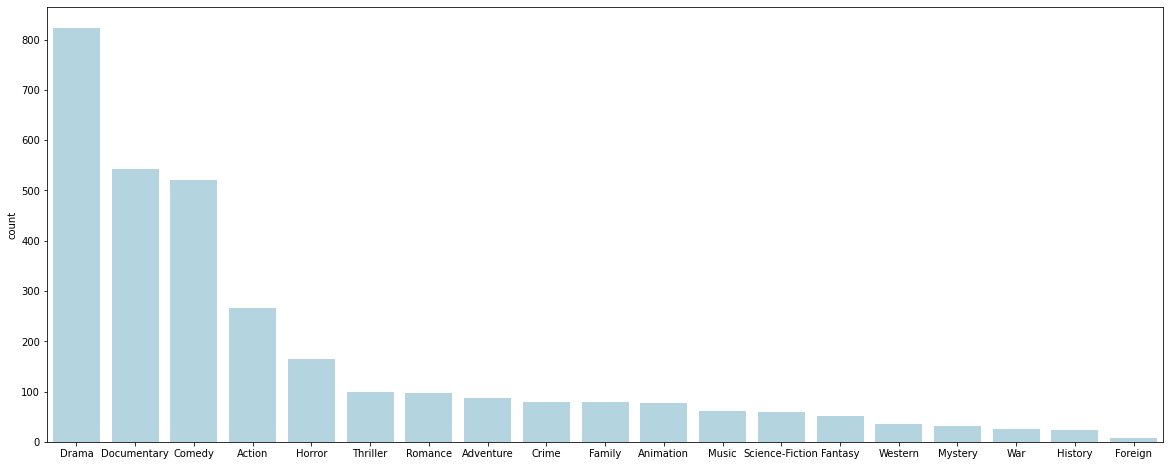

In [66]:
plt.figure(figsize = (20,8))
sns.countplot(main_genre, color = 'lightblue', order = pd.Series(main_genre).value_counts().index);

In [67]:
y = main_genre
y[:5]

['Science-Fiction', 'Adventure', 'Drama', 'Drama', 'Romance']

#### With All Genres

In [68]:
single_label_results_1 = get_single_label_results(y)
single_label_results_1

,Accuracy,Precision,Recall,F1,Train Accuracy
Original Plot with CountVectorizer,0.481659,0.407517,0.481659,0.405514,0.881085
Original Plot with TF-IDF,0.355662,0.378210,0.355662,0.241171,0.477654
Clean Plot with CountVectorizer,0.478469,0.407796,0.478469,0.402939,0.745012
Clean Plot with TF-IDF,0.350877,0.342518,0.350877,0.236442,0.415802


#### With Most Common Genres

In [69]:
top10_main_genre = pd.Series(y).value_counts().head(10)
top10_main_genre

Drama          824
Documentary    542
Comedy         521
Action         266
Horror         164
Thriller       100
Romance         98
Adventure       88
Crime           80
Family          79
dtype: int64

Now that we have the top 10 genres, we will label the rest as "Other".

In [70]:
new_y = []
for genre in y:
    if genre in top10_main_genre.index:
        new_y.append(genre)
    else:
        new_y.append('Other')

In [71]:
single_label_results_2 = get_single_label_results(new_y)
single_label_results_2

,Accuracy,Precision,Recall,F1,Train Accuracy
Original Plot with CountVectorizer,0.488038,0.466329,0.488038,0.433478,0.907023
Original Plot with TF-IDF,0.355662,0.378210,0.355662,0.241171,0.487231
Clean Plot with CountVectorizer,0.484848,0.464579,0.484848,0.430430,0.800878
Clean Plot with TF-IDF,0.350877,0.342518,0.350877,0.236442,0.419792


## Clustering

In [72]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [73]:
def cluster(transformer, corpus):
    clusterer = KMeans(n_clusters=19, random_state=1)
    doc_word = embed(transformer, corpus)

    #convert data to lower dimension
    #lsa = TruncatedSVD(2)
    #doc_word = lsa.fit_transform(doc_word)

    clusterer.fit(doc_word)
    cluster_labels = clusterer.fit_predict(doc_word)

    #plt.scatter(doc_topic[:, 0], doc_topic[:, 1], c=cluster_labels, cmap='viridis')
    
    print("The silhouette_score is:", silhouette_score(doc_word, cluster_labels))
    print("inertia is:", clusterer.inertia_)

### Original Plot with CountVectorizer

In [74]:
cluster(cv, movies_df['plot'])

The silhouette_score is: 0.00447763911970671
inertia is: 444155.66175195074


### Clean Plot with CountVectorizer

In [75]:
cluster(cv, movies_df['plot_clean'])

The silhouette_score is: 0.005822850913719729
inertia is: 337799.69994001975


### Original Plot with TF-IDF

In [76]:
cluster(tfidf, movies_df['plot'])

The silhouette_score is: 0.0023562049325364957
inertia is: 3050.706636919764


### Clean Plot with TF-IDF

In [77]:
cluster(tfidf, movies_df['plot_clean'])

The silhouette_score is: 0.004261664217158116
inertia is: 2962.9895079965972


Unfortunatly, we can see that both the classification and clustering performed poorly.